In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from functions import colorize, generate_reference, generate_complex_pattern

# I. Generate syntetic data

## I.1. Generate complex pattern, reference

Text(0.5, 1.0, 'Reference (phase slope)')

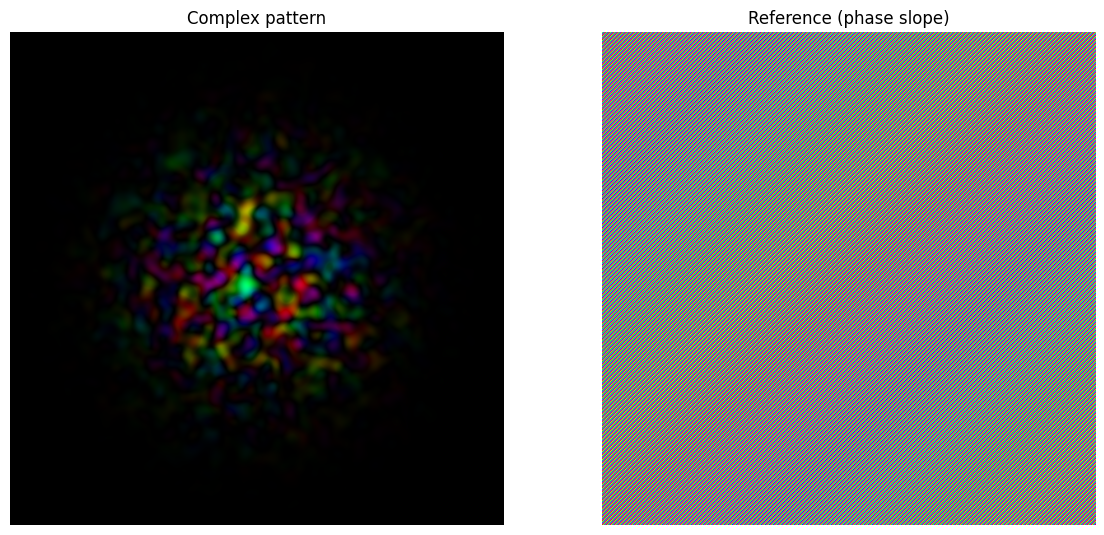

In [2]:
N = 600
# sigma of the pixel size (relative to the full window size)
sigma = 1e-2
# sigma of the envelope (relative to the full window size)
sigma_env = 0.33
# angle of the reference phase slope
angle = np.pi/4
# spatial frequency of the reference phase slope
fx, fy = 0.2,0.2


complex_pattern, X, Y = generate_complex_pattern(N, sigma, sigma_env)
reference = generate_reference(X, Y, fx, fy)


plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.imshow(colorize(complex_pattern))
plt.axis('off')
plt.title('Complex pattern')
plt.subplot(122)
plt.imshow(colorize(reference))
plt.axis('off')
plt.title('Reference (phase slope)')


## I.2. Compute interferogram

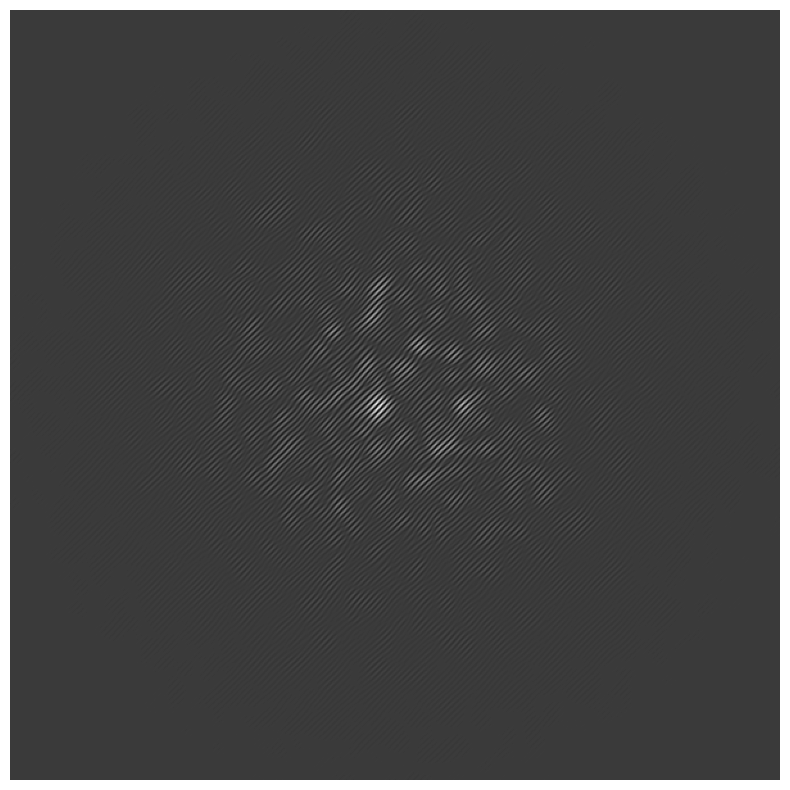

In [3]:

off_axis_intensity = np.abs(reference+complex_pattern)**2

plt.figure(figsize=(10, 10))
plt.imshow(np.abs(off_axis_intensity), cmap='gray')
plt.axis('off')
plt.show()


# II. Off-axis

## II.1. ZoomFFT

In [4]:
from scipy.signal import ZoomFFT
import numpy as np


class ZoomFFT2D:
    def __init__(self, n, m, f_center, f_range, pos_center=None, direction='forward'):
        nx, ny = n
        mx, my = m
        self.n = n
        self.m = m
        self.direction = direction

        if direction not in ['forward', 'backward']:
            raise ValueError("direction must be 'forward' or 'backward'")
        if isinstance(f_center, tuple):
            self.f_center = [f*2 for f in f_center]
        elif isinstance(f_center, float) or isinstance(f_center, int):
            self.f_center = (f_center*2, f_center*2)
        else:
            raise ValueError("f_center must be a tuple or a float")
        
        if isinstance(f_range, tuple):
            self.f_range =  [f*2 for f in f_range]
        elif isinstance(f_range, float) or isinstance(f_range, int):
            self.f_range = (f_range*2, f_range*2)
        else:
            raise ValueError("f_range must be a tuple or a float")

        if pos_center is None:
            self.pos_center = ( (self.n[0]-1) / 2, (self.n[1] -1) / 2)
        elif isinstance(pos_center, tuple):
            self.pos_center = pos_center
        else:
            raise ValueError("pos_center must be a tuple")

        self.fnx = [self.f_center[0] - self.f_range[0] / 2, self.f_center[0] + self.f_range[0] / 2]
        self.fny = [self.f_center[1] - self.f_range[1] / 2, self.f_center[1] + self.f_range[1] / 2]
        self.f1 = ZoomFFT(nx, m=mx, fn=self.fnx)
        self.f2 = ZoomFFT(ny, m=my, fn=self.fny)
        self.ref = None
        self._get_phase_ref()

    def _get_phase_ref(self):
        foc = np.zeros(self.n)

        if self.pos_center[0] % 1 == 0:
            start_x = int(self.pos_center[0]) 
            end_x = int(self.pos_center[0])+1
        else:
            start_x = int(self.pos_center[0])
            end_x = int(self.pos_center[0])+2

        if self.pos_center[1] % 1 == 0:
            start_y = int(self.pos_center[1])
            end_y = int(self.pos_center[1])+1
        else:
            start_y = int(self.pos_center[1])
            end_y = int(self.pos_center[1])+2

        foc[start_x:end_x, start_y:end_y] = 1

        ref = self(foc)
        self.ref = np.exp(-1j * np.angle(ref))

    def __call__(self, A):
        FFT = self.f1(A, axis=-2)
        FFT = self.f2(FFT, axis=-1)
        if self.direction == 'backward':
            FFT = FFT[::-1, ::-1]
        if self.ref is not None:
            return FFT * self.ref
        else:
            return FFT

## II.2. Compute Fourier transform

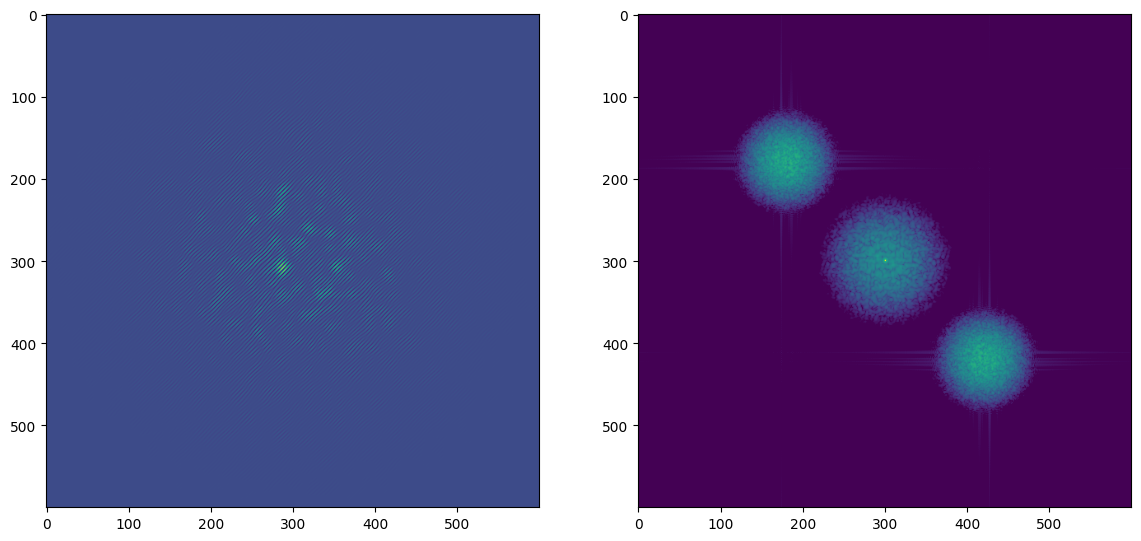

In [5]:
from matplotlib.colors import LogNorm

# Create the ZoomFFT object for the full FFT (slow!)
ft = ZoomFFT2D(off_axis_intensity.shape, off_axis_intensity.shape, 0., 1.)


ft_img = ft(off_axis_intensity)

# plt.figure(figsize=(20, 20))
# plt.imshow(frame)

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.imshow(off_axis_intensity)
plt.subplot(122)
plt.imshow(np.abs(ft_img)/np.max(np.abs(ft_img)),  norm=LogNorm(vmin=1e-6, vmax=1))
# plt.colorbar()
plt.show()




## II.3 Select the desired frequency window

Text(0.5, 1.0, 'Frequency window')

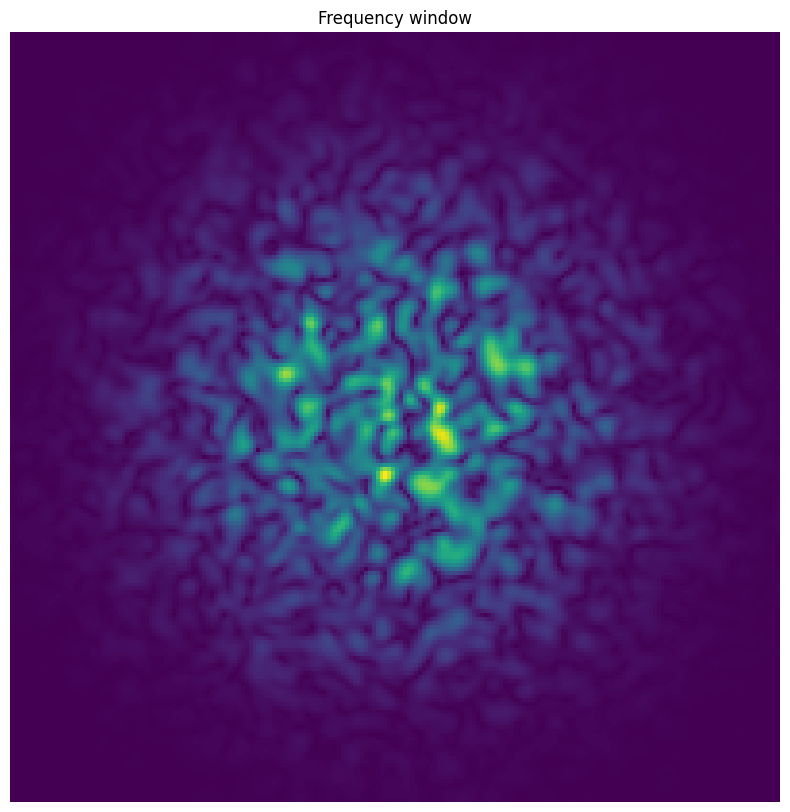

In [ ]:
f_range = 0.075*2
ft_res = 400
window_resolution = (ft_res, ft_res)


## Note that we take the minus sign to select the -1 order
## The +1 order contains the conjugate of the signal
f_center = (-fx, -fy)

ft_small = ZoomFFT2D(
    off_axis_intensity.shape, 
    window_resolution,
    f_center = f_center,
    f_range = f_range,
    )

ft_small_img = ft_small(off_axis_intensity)


plt.figure(figsize=(10, 10))
plt.imshow(np.abs(ft_small_img)/np.max(np.abs(ft_small_img)))
plt.axis('off')
plt.title('Frequency window')


## II.4. Inverse FT

In [7]:
# to recover the original pattern size, we need to set the f_range 
# in agreement with original size and the resolution of the zoomFFT window
if_range = N/ft_res*f_range


ift = ZoomFFT2D(
    ft_small_img.shape,
    off_axis_intensity.shape,
    f_center = 0.,
    f_range = if_range, 
    direction='backward'
    )
recovered_complex_pattern = ift(ft_small_img)

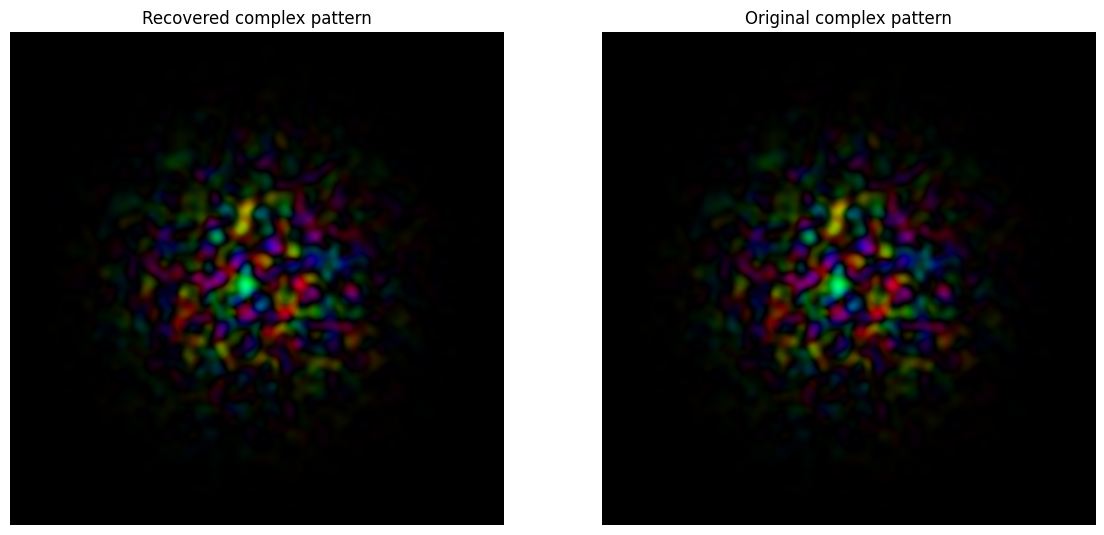

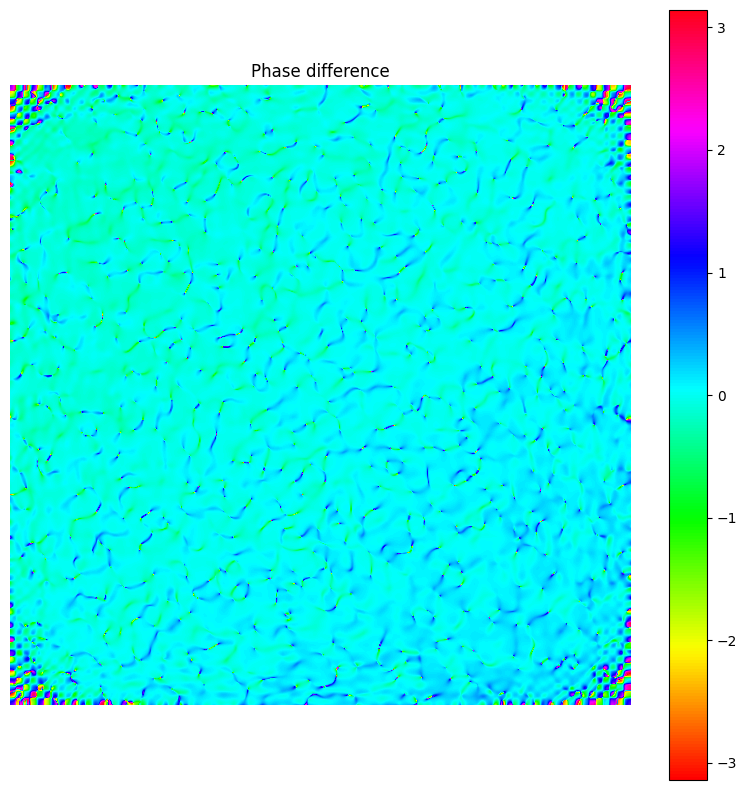

In [8]:
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.imshow(colorize(recovered_complex_pattern))
plt.axis('off')
plt.title('Recovered complex pattern')
plt.subplot(122)
plt.imshow(colorize(complex_pattern))
plt.axis('off')
plt.title('Original complex pattern')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(np.angle(recovered_complex_pattern/complex_pattern), cmap='hsv')
plt.axis('off')
plt.title('Phase difference')
plt.colorbar()


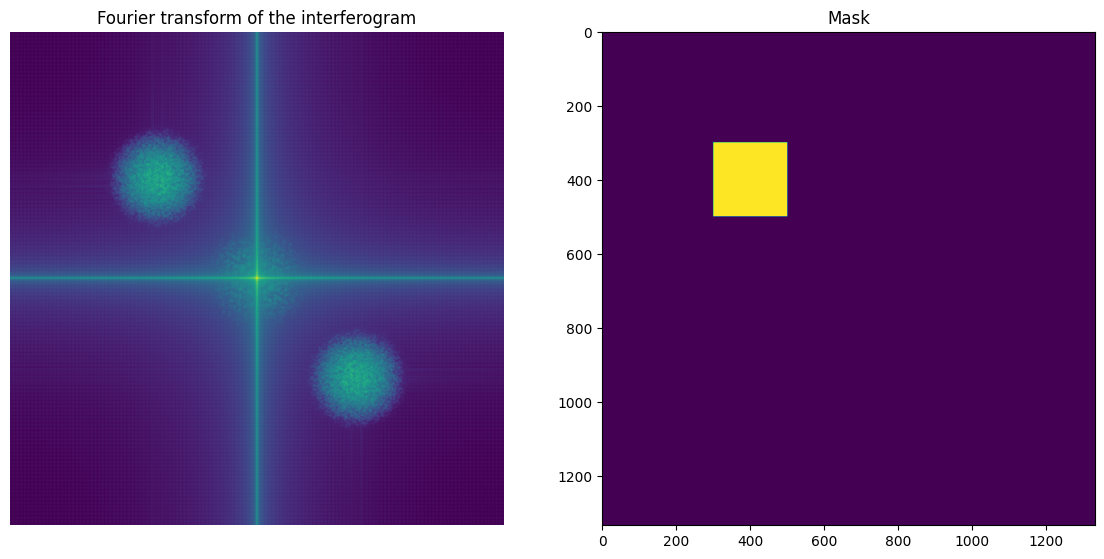

In [9]:

# coeff = 1
fft_size = [int(ft_res/f_range)]*2
# [coeff*s for s in off_axis_intensity.shape]

Fh = np.fft.fftshift(np.fft.fft2(off_axis_intensity, fft_size).astype(complex))
fft_freq = np.fft.fftshift(np.fft.fftfreq(fft_size[0]))


mask_FT_x = (fft_freq > f_center[0]-f_range/2) * (fft_freq < f_center[0]+f_range/2)
mask_FT_y = (fft_freq > f_center[1]-f_range/2) * (fft_freq < f_center[1]+f_range/2)
# outer product
mask_FT = np.outer(mask_FT_x, mask_FT_y)

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.imshow(np.abs(Fh)/np.max(np.abs(Fh)), norm=LogNorm(vmin=1e-6, vmax=1))
plt.axis('off')
plt.title('Fourier transform of the interferogram')
plt.subplot(122)
plt.imshow(mask_FT)
# plt.axis('off')
plt.title('Mask')
plt.show()



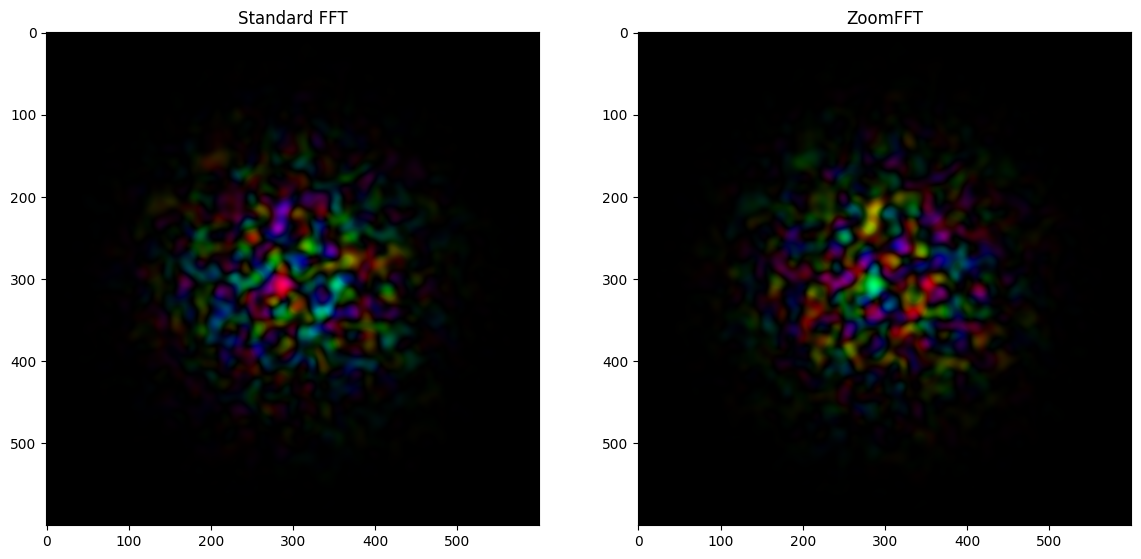

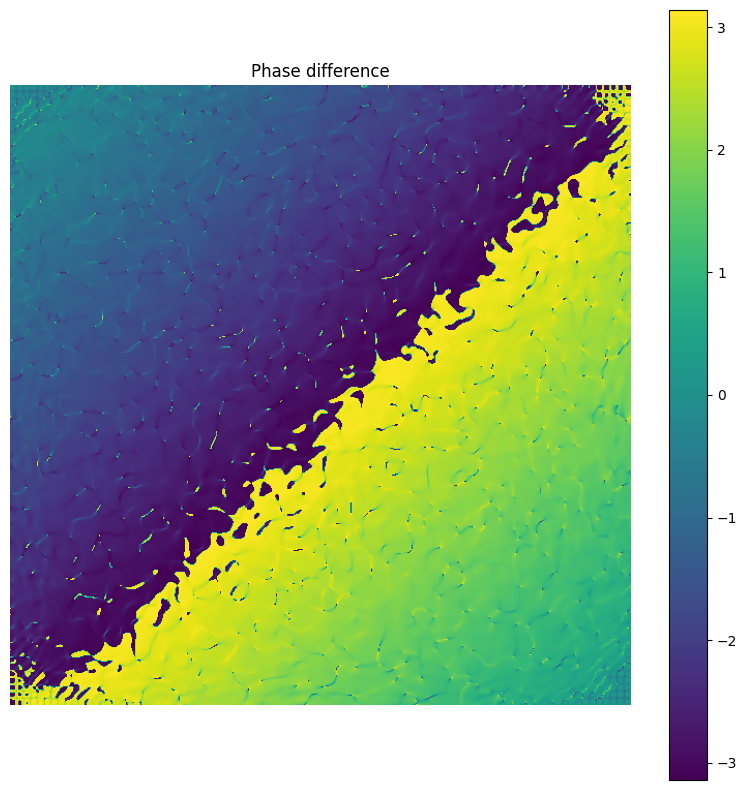

In [10]:



def do_offaxis_FFT(A, mask, f_center):
    Fh = np.fft.fftshift(np.fft.fft2(A, s = fft_size).astype(complex))
    ## Apply mask
    Fh_masked = Fh*mask
    offset = [-int(f*n) for f,n in zip(f_center,fft_size)]
    ## Recenter the FFT 
    Fh_recentered = np.roll(Fh_masked, offset[0], axis=0)
    Fh_recentered = np.roll(Fh_recentered, offset[1], axis=1)  
    ## Inverse FFT
    fft_recovered = np.fft.ifft2(np.fft.ifftshift(Fh_recentered))
    return fft_recovered[:A.shape[0], :A.shape[1]]


def do_offaxis_FFT_zoom(A):
    ft_small_img = ft_small(A)
    recovered_complex_pattern = ift(ft_small_img)
    return recovered_complex_pattern


fft_recovered_FFT = do_offaxis_FFT(off_axis_intensity, mask_FT, f_center)
fft_recovered_FFT_zoom = do_offaxis_FFT_zoom(off_axis_intensity)

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.imshow(colorize(fft_recovered_FFT))
# plt.colorbar()
# plt.axis('off')
plt.title('Standard FFT')
plt.subplot(122)
plt.imshow(colorize(fft_recovered_FFT_zoom))
# plt.axis('off')
plt.title('ZoomFFT')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(np.angle(fft_recovered_FFT/fft_recovered_FFT_zoom))
plt.axis('off')
plt.title('Phase difference')
plt.colorbar()


In [11]:
%%timeit 

fft_recovered_FFT = do_offaxis_FFT(off_axis_intensity, mask_FT, f_center)


175 ms ± 8.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit #-n 10 -r 10
fft_recovered_FFT_zoom = do_offaxis_FFT_zoom(off_axis_intensity)

28.1 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
# ift = ZoomFFT2D(
#     ft_small_img.shape,
#     ft_small_img.shape,
#     f_center = 0.,
#     f_range = if_range, 
#     direction='backward'
#     )
# def do_offaxis_FFT_zoom(A):
#     ft_small_img = ft_small(A)
#     recovered_complex_pattern = ift(ft_small_img)
#     return recovered_complex_pattern

# fft_recovered_FFT_zoom = do_offaxis_FFT_zoom(off_axis_intensity)

# plt.figure(figsize=(20, 7))
# plt.subplot(131)
# plt.imshow(colorize(fft_recovered_FFT_zoom))
# plt.axis('off')
# plt.title('ZoomFFT')
# plt.subplot(132)
# plt.imshow(colorize(fft_recovered_FFT))
# plt.axis('off')
# plt.title('standard FFT')
# plt.subplot(133)
# plt.imshow(np.angle(fft_recovered_FFT/fft_recovered_FFT_zoom))
# plt.axis('off')
# plt.title('Phase difference')
# plt.colorbar()

